# Implementation for the qFLO Algorithm

### James D. Watson

# Table of contents
1. [Introduction](#introduction)
2. [Methods](#methods)
    1. [Linear Algebra Functions](#linalg)
    2. [Simulation Functions](#simulation)
    3. [Local Observables](#observable)
3. [Hamiltonian Input from OpenFermion](#openfermion)
4. [qDRIFT Implementation](#qDRIFT)
5. [qFLO Implementation](#qFLO)
    1. [qFLO Example](#linalg)

# Introduction <a name="introduction"></a>

Here we give explicit code for the qFLO algorithm given in https://arxiv.org/abs/2411.04240

# Methods <a name="methods"></a>

## Useful Pauli and Qubit Manipulations

In [1]:
# Imports

import numpy as np
import scipy.interpolate as interp
import scipy.linalg as sla
import numpy.linalg as nla
import matplotlib.pyplot as plt
import random as rand
import pandas as pd
from mpmath import *
from datetime import datetime
from datetime import date

C:\Users\05wat\anaconda3\Lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Computes Kronecker (tensor) product of a list of matrices
# Example:
# Input: [X,Y,Z,Y]
# Return: X \ox Y \ox Z \ox Y
def kron_list(matrix_list):
    result = matrix_list[0]
    for i in range(1,len(matrix_list)):
        result = np.kron(result,matrix_list[i])
        
    return result

# Pauli matrices
I = np.array([[1.,0],[0,1.]], dtype='complex')
X = np.array([[0,1.],[1.,0]], dtype='complex')
Y = np.array([[0,-1.j],[1.j,0]], dtype='complex')
Z = np.array([[1.,0],[0,-1.]], dtype='complex')

# Converts string representation of paulis to list of matrices,
# Example:
# Input: "XYZY"
# Return: [X,Y,Z,Y]
def paulistring_to_list(paulistring): 
    matrix_list = list(paulistring)
    translate = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
    for p in range(len(paulistring)):
        matrix_list[p] = translate[matrix_list[p]]
    return matrix_list

# Computes generalized pauli matrix, given a string in standard form,
# Example:
# Input: "XYZY"
# Return: X \ox Y \ox Z \ox Y
def pauli_matrix(paulistring):
    return kron_list(paulistring_to_list(paulistring))

# Computes generalized pauli matrix, specified by non-identity pieces. Nonidentities encoded as dictionary
# of the form {k:'P', ..., } where k is the integer location and P is a pauli
# Example:
# Input: {0: 'X', 3:'Z', 5:'X'}, 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X
def sparse_pauli(nonidentities, nqubits):
    #starting string is all identity
    paulilist = []
    for i in range(0, nqubits):
        paulilist.append('I')
    
    #Change string to paulis specified by dictionary
    for key in nonidentities:
        paulilist[key] = nonidentities[key]
    paulistring = ''.join(paulilist)
    
    return pauli_matrix(paulistring) 

# Returns the matrix of \sigma . \sigma between sites i and j
# Example:
# Input: 0,1,4
# Return: X\ox X \ox I \ox I + Y\ox Y \ox I \ox I + Z\ox Z \ox I \ox I
def sigma_dot_sigma(i,j,nqubits):
    return sparse_pauli({i:'X',j:'X'},nqubits) + sparse_pauli({i:'Y',j:'Y'},nqubits) + sparse_pauli({i:'Z',j:'Z'},nqubits)

# Qubit computational basis
zero = np.array([1.,0], dtype ='complex')
one = np.array([0,1.], dtype ='complex')

# Converts a bitstring to list of single-qubit kets
# Example: 
# Input: "0101"
# Output: list( (1,0), (0,1), (1,0), (0,1) )
def bitstring_to_list(bitstring):
    bitlist = list(bitstring)
    translate = {'0':zero, '1':one}
    for b in range(len(bitstring)):
        bitlist[b] = translate[bitlist[b]]
    return bitlist

# Converts a bitstring to full vector/array describing each qubit.
# Example: 
# Input: "0101"
# Output:  (1,0) \ox (0,1) \ox (1,0) \ox (0,1) 
def basis_ket(bitstring):
    return kron_list(bitstring_to_list(bitstring))


# Outputs a bit string with certain positions set to 1, and otherwise set to zero.
# Example: 
# Input: [0,1,2],3
# Output:  (0,0,0,0,0,0,0,0,1)
def sparse_bitstring(ones, nqubits):
    bitlist = ['0']*nqubits
    
    #Flip certain bits to one, as specified by list of qubit indices
    for qubit in ones:
        bitlist[qubit] = '1'
    
    # Convert list to bitstring
    bitstring = ''.join(bitlist)
    
    return basis_ket(bitstring)

## Linear Algebra Functions <a name="linalg"></a>

In [3]:
## We are working with large matrix powers. Here we use diagonalisation rather than the repeated square method to compute
## large exponents.
## Code taken from: https://saturncloud.io/blog/numpys-matrixpower-function-understanding-and-addressing-incorrect-results-for-large-exponents/

# Computer n^th power of square, diagonalisable matrix A:
def matrix_power_eigenvalue(A, n):
    #Adjust precision
    #mp.dps = 20
    
    ## Use in-built hi-precision function:
    output =  np.array(mp.powm(A, n).tolist(), dtype=complex)
    
    return output

def matrix_power_eigenvalue_precise(A, n, precision=20):
    #Adjust precision
    mp.dps = precision
    
    
    ## Use in-built hi-precision function:
    #output =  np.array(mp.powm(A, n).tolist(), dtype=complex)
    output =  mp.powm(A, n)
   
    return output

# The old function
def matrix_power_eigenvalue_old(A, n):
   
    
    eigenvalues, eigenvectors = np.linalg.eig(A)
    D = np.diag(eigenvalues**n)
    print(D)
    output = fp.matrix( eigenvectors @ D @ np.linalg.inv(eigenvectors))
    
    
    return output

### Simulation Functions <a name="simulation"></a>

In [4]:
# Given: a positive integer, nqubits, and a list of n floats, hlist
# Generates the 1D Heisenberg chain Hamiltonian specified in the introduction.
def heisenbergH(nqubits, hlist):
    H = sigma_dot_sigma(0,1,nqubits) + hlist[0]*sparse_pauli({0:'Z'}, nqubits)
    for j in range(1, nqubits):
        H += sigma_dot_sigma(j, (j+1)%nqubits, nqubits) + hlist[j]*sparse_pauli({j:'Z'}, nqubits)
    return H

# Given a square matrix H and float T
# Returns the exact time evolution operator e^{-i H T} 
def Uexact(H, T):
    return sla.expm(-1.j*H*T)

## Returns the matrix with high precision exponentiation.
def Uexact_precise(H, T):
    
    #Adjust precision
    mp.dps = 20
    
    Uexact = mp.expm( -1.j*H*T , method='taylor')
    
    
    ## Use in-built hi-precision function:
    output =  np.array(Uexact.tolist(), dtype=complex)
    
    return output


# Computes a single time step of first or second order Trotter
# Terms in Hterms are applied to the state in increasing index (0,1,...,m)
def Utrot_short(Hterms, t, order = 1):
    m = len(Hterms) # number of terms
    result = sla.expm(-1.j*Hterms[m-1]*t)
    if order == 1:  
        for k in range(m-2,-1,-1):
            result = result @ sla.expm(-1.j*Hterms[k]*t)
    
    elif order == 2: 
        for k in range(m-2, -1, -1):
            result = sla.expm(-1.j*Hterms[k]*t/2) @ result @ sla.expm(-1.j*Hterms[k]*t/2)
    else:
        raise ValueError("Not a valid order of Trotter formula: must be 1 or 2")
    return result

# Computes a single time step of first or second order Trotter
# Terms in Hterms are applied to the state in increasing index (0,1,...,m)
def Utrot_short_precise(Hterms, t, order = 1, precision =20):
    
    #Adjust precision
    mp.dps = precision
    
    m = len(Hterms) # number of terms
    result = mp.expm(-1.j*Hterms[m-1]*t)
    if order == 1:  
        for k in range(m-2,-1,-1):
            result = result @ mp.expm(-1.j*Hterms[k]*t)
    
    elif order == 2: 
        for k in range(m-2, -1, -1):
            result = mp.expm(-1.j*Hterms[k]*t/2) @ result @ mp.expm(-1.j*Hterms[k]*t/2)
    else:
        raise ValueError("Not a valid order of Trotter formula: must be 1 or 2")
    return result
    
# Given: a list Hterms of square matrices of same dimension, float T, a (possibly noninteger) number of steps, and order =1,2
# Returns a Trotter evolution of given order and step number, for time T
def Utrot_long(Hterms, T, steps, order = 1):
    single_step = Utrot_short(Hterms, T/steps, order)
    
    integer_steps = int( np.floor(steps) )
    fractional_step = steps - integer_steps
    
    integer_step_evolve = matrix_power_eigenvalue(single_step, integer_steps)
    fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = integer_step_evolve @ fractional_step_evolve 
    
    return total_evolution

## Above, but high precision
def Utrot_long_precise(Hterms, T, steps, order = 1, precision =20):
    
    #Adjust precision
    mp.dps = precision
    
    
    single_step = Utrot_short_precise(Hterms, T/steps, order)
    
    step_evolve = matrix_power_eigenvalue(single_step, steps)
    #fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = step_evolve 
    
    return total_evolution

# Local Observable and Expectation Value Functions <a name="observable"></a>

In [5]:
## Define a Local Observable:

## Computes  Hermitian observable, specified by Pauli strings. Input is a list of dictionaries: nonidentities encoded as dictionary
## of the form {k:'P', ..., } where k is the integer location and P is a pauli. Pauli strings are then input as list.
# Example:
# Input: [{0: 'X', 3:'Z', 5:'X'}, {1: 'X'}], 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X + I\ox X \ox  I \ox I \ox I \ox I
def intialise_observable(List_Pauli_strings, nqubits):

    local_observable = 0
    for k in range(len(List_Pauli_strings)):
        local_observable +=  sparse_pauli( List_Pauli_strings[k], nqubits )
    
    return local_observable

## Take expectation value of 'observable' with respect to to 'state'
# Example:
# Input: sparse_bitstring([0], 1), observable([{0: 'Z'}], 1) 
# Output: -1
def expectation_value(state, observable):
    
    normalisation =   np.vdot(state, state )  
    # Throw an exception if the state is not normalised.
    if (normalisation -1) > 0.00001:
        raise ValueError("State is not normalised")
    
    # Calculate the expectation of the state. Use vdot to get complex conjugate.
    expectation = np.vdot(state, observable.dot(state) )
    
    # Throw an exception if there is a significant imaginary part to the expectation value.
    if np.abs(expectation.imag) > 0.00001:
        raise ValueError("Expectation value should be entirely real")
        
    # Return only the real part of the expectation value (imaginary part should be zero).
    return np.real(expectation)

## Finds the expectation value with respect to the Trotterized time evolution. Define the function in terms of s = 1/steps.
# Example: 
# Input: [Even, Odd, Potential], sparse_bitstring([0,1], 2), 10, 0.01, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Trotterized_Expectation(Hterms, initial_state, time, s, observable, order = 1):
    
    steps = 1/s
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long(Hterms, time, steps, order)
    time_evolved_state = Trotterized_evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)

## High Precision Version of above.
def Trotterized_Expectation_precise(Hterms, initial_state, time, s, observable, order = 1):
    
    steps = 1/s
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long_precise(Hterms, time, steps, order)
    time_evolved_state = Trotterized_evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)
    
## Computes the time-evolved expectation value from the *exact* evolution.  
# Example: 
# Input: heisenbergH(nqubits, hlist), sparse_bitstring([0,1], 2), 10, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Exact_Expectation(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)


## Precise version of the above.
def Exact_Expectation_Precise(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact_precise(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)


## Computes the magnetisation as a matrix.
# Example:
# Input: 5
# Output: (1/5)\sum_{i=1}^5 Z_i
def Magnetisation(nqubits):
    
    magnetisation_list = []
    
    # For each qubit we want to measure Z on that qubit and then add them together. Generate the Pauli string
    # representing this operator.
    for k in range(nqubits):
        magnetisation_list.append( { k : 'Z'} )
        
    # Calculate the matrix form of the local observable.
    magnetisation_matrix = (1/nqubits)*observable(magnetisation_list, nqubits)
    
    return magnetisation_matrix

# Hamiltonian Input from OpenFermion <a name="openfermion"></a>

In [6]:
### This takes the values stored without going through OpenFermion

#H2
H2_operator = [['-0.16733398905695251', ''], ['-0.046156695889015324', 'X0 X1 Y2 Y3'], ['0.046156695889015324', 'X0 Y1 Y2 X3'], ['0.046156695889015324', 'Y0 X1 X2 Y3'], ['-0.046156695889015324', 'Y0 Y1 X2 X3'], ['0.16251648748871642', 'Z0'], ['0.16583253721590402', 'Z0 Z1'], ['0.11720364720195847', 'Z0 Z2'], ['0.1633603430909738', 'Z0 Z3'], ['0.16251648748871642', 'Z1'], ['0.1633603430909738', 'Z1 Z2'], ['0.11720364720195847', 'Z1 Z3'], ['-0.19744293699755816', 'Z2'], ['0.17169788392286725', 'Z2 Z3'], ['-0.19744293699755816', 'Z3']]

#LiH
LiH_operator = [['-7.49894690201071', ''], ['-0.0029329964409502266', 'X0 X1 Y2 Y3'], ['0.0029329964409502266', 'X0 Y1 Y2 X3'], ['0.01291078027311749', 'X0 Z1 X2'], ['-0.0013743761078958677', 'X0 Z1 X2 Z3'], ['0.011536413200774975', 'X0 X2'], ['0.0029329964409502266', 'Y0 X1 X2 Y3'], ['-0.0029329964409502266', 'Y0 Y1 X2 X3'], ['0.01291078027311749', 'Y0 Z1 Y2'], ['-0.0013743761078958677', 'Y0 Z1 Y2 Z3'], ['0.011536413200774975', 'Y0 Y2'], ['0.16199475388004184', 'Z0'], ['0.011536413200774975', 'Z0 X1 Z2 X3'], ['0.011536413200774975', 'Z0 Y1 Z2 Y3'], ['0.12444770133137588', 'Z0 Z1'], ['0.054130445793298836', 'Z0 Z2'], ['0.05706344223424907', 'Z0 Z3'], ['0.012910780273117487', 'X1 Z2 X3'], ['-0.0013743761078958677', 'X1 X3'], ['0.012910780273117487', 'Y1 Z2 Y3'], ['-0.0013743761078958677', 'Y1 Y3'], ['0.16199475388004186', 'Z1'], ['0.05706344223424907', 'Z1 Z2'], ['0.054130445793298836', 'Z1 Z3'], ['-0.013243698330265966', 'Z2'], ['0.08479609543670981', 'Z2 Z3'], ['-0.013243698330265952', 'Z3']]

In [7]:
## Functions for converting outputs of the Hamiltonian to the 

# Remove the identity terms to get only the non-trivial terms.
def remove_identity(Hamiltonian):
    reduced_Hamiltonian = Hamiltonian
    for element in reduced_Hamiltonian:
        if element[1]=='':
            reduced_Hamiltonian.remove(element)

    return reduced_Hamiltonian
            
# Convert the openfermion operator to our form.
# Input: [['-0.5', 'X0 X1 Y2 Y3'], ['2', 'X0 Y1 Y2 X3']]
# Output: [[-0.5, {0: 'X', 1: 'X', 2: 'Y', 3: 'Y'}], [2, {0: 'X', 1: 'Y', 2: 'Y', 3: 'X'}]]
def openfermion_to_local_rep(of_Hamiltonian):
    local_representation = []
    for element in of_Hamiltonian:
        coefficient     = float(element[0]) 
        element_strings = element[1].split(' ')
        local_operator  = {}
        for op_string in element_strings:
            local_operator[int(op_string[1])]=op_string[0]

        local_representation.append( [ coefficient, local_operator  ] )

    return local_representation

# Transforms into explicit matrix representation.
# Takes input from openfermion_to_local_rep
def local_matrix_representation(local_rep_Hamiltonian, nqubits):
    matrix_representation = []
    for element in local_rep_Hamiltonian:
        matrix_representation.append( [element[0], sparse_pauli(element[1], nqubits)])

    return matrix_representation

# Generates the full explicit matrix of the Hamiltonian.
def explicit_Hamiltonian_matrix(local_matrix_representation):
    Hamiltonian_matrix = 0
    for element in local_matrix_representation:
        Hamiltonian_matrix += element[0]*element[1]

    return Hamiltonian_matrix


In [8]:
## Tests
test_op = remove_identity(H2_operator)

new_rep = openfermion_to_local_rep(test_op)

local_mat_rep = local_matrix_representation(new_rep, 4)

Hamiltonian_matrix = explicit_Hamiltonian_matrix(local_mat_rep)
#print(len(test_op))
#print(Hamiltonian_matrix)

# qDRIFT Implementation <a name="qDRIFT"></a>

In [112]:
import random

## Takes a list of coefficients and terms and then sums them cummulatively.
def cumulative_Hamiltonian_rep(local_rep_Hamiltonian):
    running_total = 0
    cumulative_representation = []
    
    for element in local_rep_Hamiltonian:
        running_total += np.abs( element[0] )
        cumulative_representation.append( [ running_total,  element[1] ] )

    return cumulative_representation


# Samples an index with probability proportional to weight.
def sample_local_index(local_rep_Hamiltonian, no_samples):
    """
    Samples an index from the array with a probability proportional to the absolute value of the number.

    Parameters:
        arr (list): List of numbers (can be positive or negative).

    Returns:
        int: Index of the sampled number.
    """
    
    # Compute the absolute values
    abs_values = [abs(x[0]) for x in local_rep_Hamiltonian]
    

    # Compute the total sum of absolute values
    total_abs = sum(abs_values)

    if total_abs == 0:
        raise ValueError("The sum of absolute values in the array must not be zero.")

    # Compute probabilities
    probabilities = [value / total_abs for value in abs_values]

    # Sample an index based on probabilities
    sampled_index = random.choices(range(len(abs_values)), weights=probabilities, k=no_samples)

    return sampled_index



### FUNCTION IS DEPRECIATED
# Given x and an ordered array, find the largest integer smaller than x.
def find_largest_smaller_index(arr, x):
    """
    Finds the index of the largest number in a sorted array that is smaller than x.

    :param x: float, the target value.
    :param arr: list of floats in increasing order.
    :return: int, the index of the largest number smaller than x, or -1 if no such number exists.
    """
    # Check for empty array or all elements greater than or equal to x
    if not arr or x <= arr[0]:
        return -1

    # Binary search to find the largest number smaller than x
    low, high = 0, len(arr) - 1
    result = -1

    while low <= high:
        mid = (low + high) // 2
        if arr[mid] < x:
            result = mid  # Update result since arr[mid] is smaller than x
            low = mid + 1
        else:
            high = mid - 1

    return result


### FUNCTIONS TO DEPRECIATE
def terms_to_implement(random_samples, cummulative_rep_Hamiltonian):
    """
    Takes the set of samples and picks the corresponding term from the local description of the Hamiltonian
    :param random_samples: list of floats, the samples.
    :param cummulative_rep_Hamiltonian: list of lists, each term in the inner list is a pair of the cummulative sum of coefficients and the second element is the local matrix term.
    """
    
    cummulative_array = [x[0] for x in cummulative_rep_Hamiltonian]
    cummulative_array.insert(0,0)
    index_list = []

    for sample in random_samples:
        entry = find_largest_smaller_index(cummulative_array, sample)
        index_list.append(entry)
        #print("Sample, index:", sample, entry, "|", index_list[-1], cummulative_array[entry], cummulative_rep_Hamiltonian[entry][0])
    
    return index_list

## Function now depreciated
'''
def qDRIFT_observable(local_rep_Hamiltonian, initial_state, observable, nqubits, time, no_timesteps):
    """
    Single-shot implementation of the qDRIFT protocol.
    """

    local_mat_rep = local_matrix_representation(local_rep_Hamiltonian, nqubits)
    cumulative_Hamiltonian = cumulative_Hamiltonian_rep(local_mat_rep)
    lambda_param = cumulative_Hamiltonian[-1][0]

    # Calculate the number of timesteps needed for a particular precision.
    timestep = time/no_timesteps 

    # List of samples.
    #samples = lambda_param*np.random.rand(int(no_timesteps))

    # Now generate the corresponding terms.
    #list_of_indicies = terms_to_implement( samples, cumulative_Hamiltonian) 

    # Now generate the corresponding terms.
    list_of_indicies = sample_local_index(local_mat_rep, int(no_timesteps) )
    
    # Generate the unitary:
    state = initial_state
    for index in list_of_indicies:
        #state =  sla.expm(-(1j)*lambda_param*timestep*np.sign(cumulative_Hamiltonian[index][0])*np.matrix(local_mat_rep[index][1])) @ state
        state = sla.expm(-(1j)*lambda_param*timestep*np.sign(cumulative_Hamiltonian[index][0])*np.matrix(local_mat_rep[index][1])).dot(state)
    # Find the expected value relative to the time-evolved state.
    expect_val = expectation_value(state, observable)
    return expect_val
'''

def qDRIFT_observable(local_rep_Hamiltonian, initial_state, observable, nqubits, time, no_timesteps):

    local_mat_rep = local_matrix_representation(local_rep_Hamiltonian, nqubits)
    temp = [abs(element[0]) for element in local_mat_rep]
    lambda_param = sum(temp)
    
    # Now generate the corresponding terms.
    list_of_indicies = sample_local_index(local_mat_rep, int(no_timesteps) )

    state = initial_state
    timestep = time/no_timesteps
    
    for index in list_of_indicies:
        state = sla.expm(-(1j)*timestep*np.sign(local_mat_rep[index][0])*local_mat_rep[index][1]) @ state

    expectation = expectation_value(state, observable)

    return expectation


# Average the qDRIFT values over multiple runs.
def qDRIFT_average(local_rep_Hamiltonian, initial_state, observable, nqubits, time, no_timesteps, shot_no):
    """
    Takes average over multiple qDRIFT runs.
    """
    results_array = []
    j = 0
    while j<= shot_no:
        results_array.append(qDRIFT_observable(local_rep_Hamiltonian, initial_state, observable, nqubits, time, no_timesteps))
        j += 1

    mean = sum(results_array)/len(results_array)

    return mean

    

#### Short Test Case for qDRIFT

In [152]:
### Implement H2 Time evolution.

H2_operator  = remove_identity(H2_operator)
H2_local_rep = openfermion_to_local_rep(H2_operator)


cumulative_H2_Hamiltonian = cumulative_Hamiltonian_rep(H2_local_rep)
lambda_param = cumulative_H2_Hamiltonian[-1][0]

nqubits = 4
time =0.5
#observable = intialise_observable([{0: 'X', 2:'Z', 3:'Z'}, {1: 'X'}, {2:'Y'},{3:'Y'}, {3:'Z'}, {0:'Z', 1:'X'}, {0:'Z', 2:'Z'}], nqubits)
observable = intialise_observable([{0:'Y', 1:'Y'}, {1:'Z'}, {2:'Y', 3:'Z'}, {3:'Z'}], nqubits)
#state = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
state = (1/np.sqrt(2))*np.array(sparse_bitstring([0,2], 4))+(1/np.sqrt(2))*np.array(sparse_bitstring([1,3], 4))
#state  = np.array(sparse_bitstring([0,2], 4))
epsilon = 0.03
no_timesteps = np.ceil( 2*time**2*lambda_param**2/epsilon )


#test_val = qDRIFT_observable(H2_local_rep , state, observable, nqubits, time, no_timesteps )

test_avg = qDRIFT_average(H2_local_rep , state, observable, nqubits, time, no_timesteps, 50 )
print("avg:", test_avg)

avg: -3.866017860538909e-05


In [97]:
## True value from perfect evolution:
#state = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
#state = np.array(sparse_bitstring([0,2], 4))
state = (1/np.sqrt(2))*np.array(sparse_bitstring([0,2], 4))+(1/np.sqrt(2))*np.array(sparse_bitstring([1,3], 4))
full_H2_Hamiltonian = 0
H2_list = local_matrix_representation(H2_local_rep, nqubits)
for element in H2_list:
    full_H2_Hamiltonian += element[0]*element[1]


final_state = sla.expm(-(1j)*time*np.matrix(full_H2_Hamiltonian)) @ state
perfect_val  = expectation_value(final_state, observable)

print("Ideal value:", perfect_val)

Ideal value: 0.0


In [98]:
## Check against Trotterisation

hterms = [ x[0]*x[1] for x in  local_mat_rep ]

print("Value from Trotterization:", Trotterized_Expectation(hterms, state, time, 1/no_timesteps, observable, order = 1))

Value from Trotterization: 4.812955589628132e-12


# qFLO Implementation <a name="qFLO"></a>

In [158]:
### Here implement the qFLO procedure.

def richardson_estimate(order, s_min, Hamiltonian_local_rep, initial_state, time, observable, nqubits , shot_no, circuit_depth_flag= 0):
    '''
    Construct a Richardson estimator using the terms starting from s_min. 
    '''
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    x_array = []
    y_array = []
    R_scale = np.sqrt(8)*order/np.pi

    
    for j in range( order):
        counter = j+1
        
        #Generate points to be sampled from.
        ## Define parameters used for rescaling:
        x0 = (np.sin(np.pi*(2*order-1)/(4*order) ))**2
        y0 =  np.ceil( (1/s_min)*np.ceil(  R_scale/x0)**2 )

        # Calculate the points to sample from.
        x_array.append( (np.sin(np.pi*(2*counter-1)/(4*order) ))**2 )
        y_array.append( np.ceil( (1/s_min)*np.ceil( np.ceil(  R_scale/x_array[j])**2 )/y0  )) 
        print(x_array, "Sampled points",y_array)
        #Generate expectation values at those points.

        no_timesteps = y_array[j]
        points_array.append(no_timesteps)
        qDRIFT_val   = qDRIFT_average( Hamiltonian_local_rep, initial_state, observable, nqubits, time, no_timesteps, shot_no )
        print("qDRIFT value:",qDRIFT_val)
        values_array.append( qDRIFT_val )
        maximum_circuit_depth = max(points_array)

    #Now generate the coefficients (b_j).
    for j in range(order):
        counter = j+1
        coefficient = 1
        for k in range(order):
            if k != j:
                print(y_array[k],y_array[j])
                coefficient = coefficient*(1/(1-y_array[k]/y_array[j]))
        coefficient_array.append( coefficient )

    # Compute the Richardson estimator.
    for j in range(order):
        estimate += coefficient_array[j]*values_array[j]
        estimate_array.append(estimate)
    
    if circuit_depth_flag == 0:
        return estimate

    if circuit_depth_flag == 1:
        
        return [estimate, maximum_circuit_depth]
    


In [159]:
# Test Richardson Extrapolation with H2 Hamiltonian.
no_timesteps = np.ceil( 2*time**2*lambda_param**2/epsilon )
s_min   = 1/no_timesteps
shot_no = 50
order = 3
#state = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
state = (1/np.sqrt(2))*np.array(sparse_bitstring([0,2], 4))+(1/np.sqrt(2))*np.array(sparse_bitstring([1,3], 4))


qFLO_estimate = richardson_estimate(order, s_min, H2_local_rep, state, time, observable, nqubits , shot_no)
print("qFLO Estimate:", qFLO_estimate)

[0.06698729810778066] Sampled points [187.0]
qDRIFT value: 8.292111381930431e-05
[0.06698729810778066, 0.5000000000000001] Sampled points [187.0, 4.0]
qDRIFT value: 0.002251100288768564
[0.06698729810778066, 0.5000000000000001, 0.9330127018922194] Sampled points [187.0, 4.0, 1.0]
qDRIFT value: 0.0
4.0 187.0
1.0 187.0
187.0 4.0
1.0 4.0
187.0 1.0
4.0 1.0
qFLO Estimate: 1.9583316960128017e-05


## qFLO Example Usage: LiH <a name="example"></a>

In [188]:
# Here we provide an example with the correct parameters to evaluate performance.

LiH_operator  = remove_identity(LiH_operator)
LiH_local_rep = openfermion_to_local_rep(LiH_operator)
cumulative_LiH_Hamiltonian = cumulative_Hamiltonian_rep(LiH_local_rep)
lambda_param = cumulative_LiH_Hamiltonian[-1][0]

## Parameters to use.
qubits = 4
epsilon = 0.001
time    = 1
#shot_no = 1/epsilon**2
shot_no = 1/epsilon**2
s_min   = 1/np.ceil( 2*time**2*lambda_param**2/epsilon )
observable = intialise_observable([{0: 'X', 2:'Z', 3:'Z'}, {1: 'X'}, {2:'X'},{3:'X'}, {3:'Z'}, {0:'Z', 1:'X'}], nqubits)
state   = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
max_order = 4




## Compute ideal expectation value:
state   = (1/np.sqrt(2))*np.array(sparse_bitstring([nqubits//2], nqubits))+ (1/np.sqrt(2))*np.array(sparse_bitstring([1], nqubits))
full_LiH_Hamiltonian = 0
for element in H2_list:
    full_LiH_Hamiltonian += element[0]*element[1]

final_state  = sla.expm(-(1j)*time*np.matrix(full_LiH_Hamiltonian)) @ state
perfect_val  = expectation_value(final_state, observable)

print("Ideal value:", perfect_val)

Ideal value: 0.9999999999999998


In [189]:
error_array = []
circuit_depth_array = []

for order in range(1,max_order):
    [LiH_qFLO_estimate, max_circuit_depth] = richardson_estimate(order, s_min, LiH_local_rep, state, time, observable, nqubits , shot_no, circuit_depth_flag=1)
    circuit_depth_array.append(max_circuit_depth)
    error = abs(perfect_val - LiH_qFLO_estimate)
    error_array.append(error)

[0.5000000000000001] Sampled points [1.0]
qDRIFT value: 0.8976228214354873
[0.14644660940672624] Sampled points [19.0]
qDRIFT value: 0.9902511644515947
[0.14644660940672624, 0.8535533905932737] Sampled points [19.0, 1.0]
qDRIFT value: 0.9065436544224367
1.0 19.0
19.0 1.0
[0.06698729810778066] Sampled points [187.0]
qDRIFT value: 0.9966793136770191
[0.06698729810778066, 0.5000000000000001] Sampled points [187.0, 4.0]
qDRIFT value: 0.964279270229667
[0.06698729810778066, 0.5000000000000001, 0.9330127018922194] Sampled points [187.0, 4.0, 1.0]
qDRIFT value: 0.8984724245771014
4.0 187.0
1.0 187.0
187.0 4.0
1.0 4.0
187.0 1.0
4.0 1.0


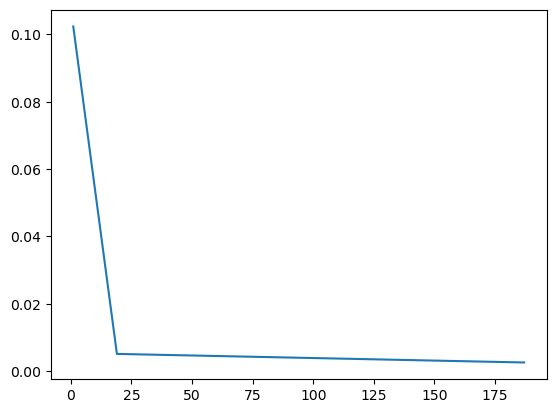

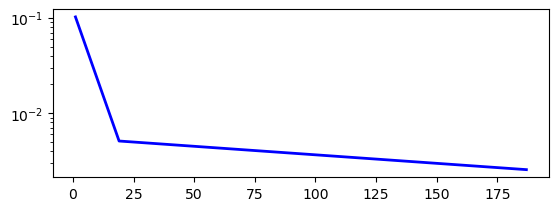

In [191]:
import matplotlib.pyplot as plt

fig = plt.plot(circuit_depth_array, error_array)  # Plot the chart
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

line, = ax.semilogy(circuit_depth_array,error_array, color='blue', lw=2)


In [143]:
counter = 4
order = 4
R_scale = np.sqrt(8)*order/np.pi
x0 = (np.sin(np.pi*(2*order-1)/(4*order) ))**2
y0 = np.ceil( (1/s_min)*np.ceil(  R_scale/x0)**2 )
x= (np.sin(np.pi*(2*counter-1)/(4*order) ))**2
y = np.ceil( (1/s_min)*np.ceil(  R_scale/x)**2 ) 

y_correct = np.ceil( (1/s_min)*np.ceil( np.ceil(  R_scale/x)**2 )/np.ceil( np.ceil(  R_scale/x0)**2 ) )

print(x,y, x0, y0, y_correct) ## Smaller counter values give larger numbers of steps.

0.9619397662556434 880.0 0.9619397662556434 880.0 55.0
